---
<h1 style="text-align: center;">
Temperature Prediction Using Regression Models with PySpark and Gradient Boosting
</h1>

<h1 style="text-align: center;">
Task 4
</h1>

<h3 style="text-align: center;">
Nov-12-2024
</h3>

---

### Weather impacts life each and every day in both relatively minor and significant ways. Many people check the weather daily to know what the predicted temperature and precipitation will be so they can plan how to dress, what activities to do, and how early to leave on their daily commute.

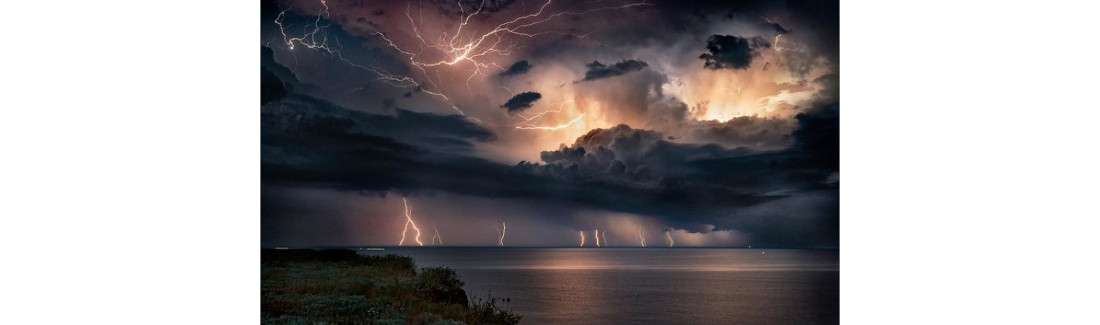

Image from https://www.un.org/en/un-chronicle/future-weather-climate-and-water-across-generations


### In this assignment, your task is to predict the temperature (in degrees Celcius) at different points in time. You need to use machine learning and develop regression models to accomplish this task. The only data you have available is the weather data in the dataset `weather_dataset.csv`. Each row in the dataset is a different point in time and the columns are the features consisting of Date and Daily Summary, and many features computed from Visibility, Wind Speed and Bearing, Humidity, Pressure, and Loud Cover. The target variable is in column "Temperature (C)".

### You must clean and preprocess the data then decide which regression algorithms to use, which and how to tune any hyperparameters, how to measure performance, which models to select, and which final model to use. 

### Also submit a short report of your work describing all steps you took, explanations of why you took those steps, results, what you learned, how you might use what you learned in the future, and your conclusions.

---

### Write your code here

In [1]:
from IPython.core.display import HTML
display(HTML("<style>pre { white-space: pre !important; }</style>"))
import gc
gc.collect()

191

In [2]:
import os
import torch
from torch import nn
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import torch.nn as nn
import torch.optim as optim
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from torch.utils.data import DataLoader, TensorDataset
from torch.utils.tensorboard import SummaryWriter

device = (
    "cuda"
    if torch.cuda.is_available()
    else "cpu"
    if torch.backends.mps.is_available()
    else "mps"
)
print(f"Using {device} device")

Using mps device


In [3]:
from pyspark.sql import SparkSession

spark = SparkSession.builder.getOrCreate()

df = spark.read.csv("data/weather_dataset.csv", header = True)

df.show()

25/01/05 16:57:48 WARN Utils: Your hostname, Garvs-MacBook-Pro.local resolves to a loopback address: 127.0.0.1; using 192.168.1.78 instead (on interface en0)
25/01/05 16:57:48 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
25/01/05 16:57:49 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
25/01/05 16:57:51 WARN SparkStringUtils: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


+--------------------+--------------------+-------------------+-------------------+--------------------+-------------------+-------------------+-------------------+---------+---------+-------------------+----------+-------------------+-------------------+--------------------+-------------------+-------------------+-------------------+----------+-------------------+------------------+------------------+-------------------+-------------------+-------------------+-------------------+-------------------+-------------------+-------------------+-------------------+-------------------+-------------------+-------------------+-------------------+-------------------+-------------------+-------------------+------------------+------------------+-------------------+-------------------+-------------------+--------------------+-------------------+-------------------+-------------------+-------------------+-------------------+-------------------+-------------------+-------------------+----------------

In [4]:
from pyspark.sql import DataFrame
import pyspark.sql.functions as F

num_samples = df.count()
num_features = len(df.columns)
print(f"Number of samples: {num_samples}")
print(f"Number of features: {num_features-3}") 

df.describe().show()

Number of samples: 96453
Number of features: 106


25/01/05 16:57:57 WARN DAGScheduler: Broadcasting large task binary with size 1040.6 KiB


+-------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+------------------+------------------+--------------------+------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+----------+--------------------+------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+-

In [5]:
# Converting String Features to Floats
from pyspark.sql.functions import col, expr
from pyspark.ml.functions import vector_to_array

feature_cols = df.columns[1:-2] 
temperature_col = df.columns[-1]
daily_summary = df.columns[-2]

df = df.select(*[col(c).cast("float").alias(c) if c in feature_cols + [temperature_col] else col(c) for c in df.columns])

df.printSchema()

root
 |-- Formatted Date: string (nullable = true)
 |-- feature_0: float (nullable = true)
 |-- feature_1: float (nullable = true)
 |-- feature_2: float (nullable = true)
 |-- feature_3: float (nullable = true)
 |-- feature_4: float (nullable = true)
 |-- feature_5: float (nullable = true)
 |-- feature_6: float (nullable = true)
 |-- feature_7: float (nullable = true)
 |-- feature_8: float (nullable = true)
 |-- feature_9: float (nullable = true)
 |-- feature_10: float (nullable = true)
 |-- feature_11: float (nullable = true)
 |-- feature_12: float (nullable = true)
 |-- feature_13: float (nullable = true)
 |-- feature_14: float (nullable = true)
 |-- feature_15: float (nullable = true)
 |-- feature_16: float (nullable = true)
 |-- feature_17: float (nullable = true)
 |-- feature_18: float (nullable = true)
 |-- feature_19: float (nullable = true)
 |-- feature_20: float (nullable = true)
 |-- feature_21: float (nullable = true)
 |-- feature_22: float (nullable = true)
 |-- feature_23:

In [6]:
# Replacing Missing Values
from pyspark.sql.functions import to_date, isnan, when, count

print("Before Missing Values Replacement:")
df.show(10)

print("Number of null values in each column:")
df.select([count(when(col(c).isNull() | isnan(col(c)), c)).alias(c) for c in feature_cols]).show()

for col_name in feature_cols:
    col_median = df.agg(F.median(F.col(col_name)).alias('median')).collect()[0][0]
    df = df.fillna({col_name: col_median})

# Used median to fill in missing values here, as the distribution is skewed, and the median is less sensitive to outliers.

# Drop duplicate samples
total_rows = df.count()  
distinct_rows = df.distinct().count()  
duplicate_rows = total_rows - distinct_rows  

print(f"Total rows before dropping duplicates: {total_rows}")
print(f"Distinct rows before dropping duplicates: {distinct_rows}")
print(f"Number of duplicate rows: {duplicate_rows}")

df = df.dropDuplicates()

print("After Missing Values Replacement and Dropping Duplicate values:")
df.show(10)

# Here replacing missing values was more helpful as most of the samples would have been removed if dropping duplicates first, so filling 
# missing spaces with median values was more useful.

Before Missing Values Replacement:
+--------------------+-----------+----------+---------+----------+----------+----------+----------+---------+---------+----------+----------+----------+----------+-----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+-----------+-----------+----------+----------+----------+----------+----------+----------+-----------+----------+----------+----------+----------+-----------+-----------+----------+----------+-----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+-----------+----------+----------+----------+--

+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+--------

25/01/05 16:58:05 WARN GarbageCollectionMetrics: To enable non-built-in garbage collector(s) List(G1 Concurrent GC), users should configure it(them) to spark.eventLog.gcMetrics.youngGenerationGarbageCollectors or spark.eventLog.gcMetrics.oldGenerationGarbageCollectors


Total rows before dropping duplicates: 96453
Distinct rows before dropping duplicates: 96212
Number of duplicate rows: 241
After Missing Values Replacement and Dropping Duplicate values:


+--------------------+----------+----------+----------+----------+----------+----------+---------+---------+---------+----------+----------+----------+-----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+-----------+----------+----------+----------+-----------+----------+----------+----------+----------+----------+----------+----------+-----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+-----------+----------+-----------+----------+----------+----------+----------+----------+-----------+----------+----------+----------+----------+----------+-----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+-----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----

In [7]:
# Outlier Detection and Removal using IQR
from pyspark.sql.functions import col

initial_count = df.count()

numeric_cols = feature_cols  

for col_name in numeric_cols:
    quantiles = df.approxQuantile(col_name, [0.25, 0.75], 0.05)
    Q1 = quantiles[0]
    Q3 = quantiles[1]
    IQR = Q3 - Q1

    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    # Filter the dataframe to exclude outliers in this column
    df = df.filter((col(col_name) >= lower_bound) & (col(col_name) <= upper_bound))

final_count = df.count()

outliers_removed = initial_count - final_count

print(f"Number of outliers removed: {outliers_removed}")
print("After Outlier Removal:")
df.show(10)

Number of outliers removed: 17134
After Outlier Removal:


+--------------------+----------+----------+-----------+----------+-----------+----------+----------+---------+---------+----------+----------+----------+-----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+-----------+----------+----------+----------+-----------+----------+----------+----------+-----------+----------+----------+----------+----------+----------+----------+-----------+----------+----------+----------+----------+----------+-----------+----------+-----------+----------+-----------+----------+----------+----------+----------+----------+-----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+-----------+----------+----------+----------+----------+

Correlation between Hour and Temperature (C): 0.23055405994372663
Correlation between Month and Temperature (C): 0.17425113291226318


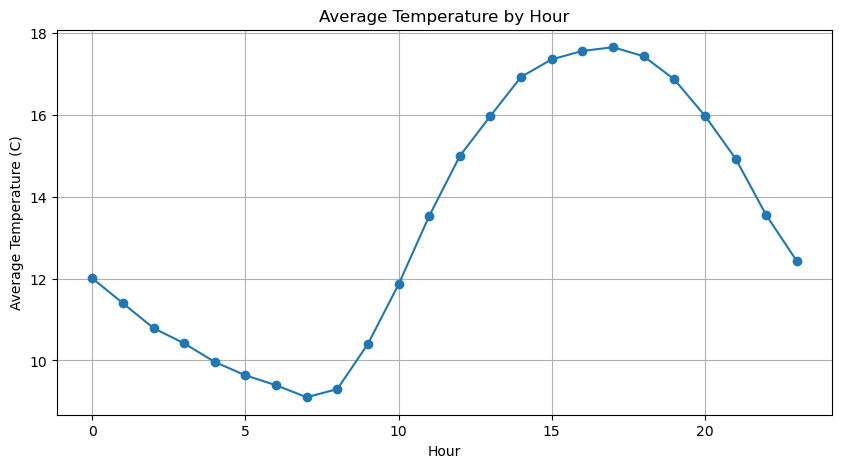

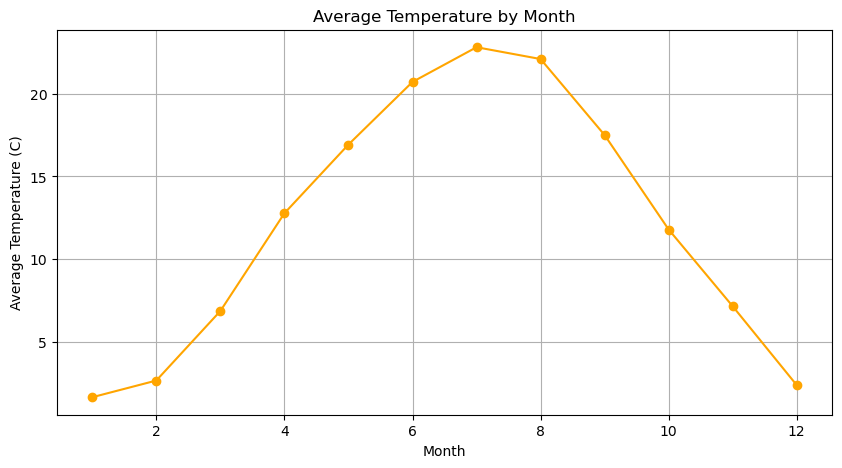

In [8]:
# Feature Engineering for Formatted Date 
from pyspark.sql.functions import hour, dayofmonth, month, year, to_timestamp
import matplotlib.pyplot as plt

df = df.withColumn("Hour", hour(to_timestamp("Formatted Date", "yyyy-MM-dd HH:mm:ss.SSS Z"))) \
             .withColumn("Month", month(to_timestamp("Formatted Date", "yyyy-MM-dd HH:mm:ss.SSS Z"))) 

# Correlation between Hour, Month and Temperature (C)
cor_hour = df.stat.corr("Hour", "Temperature (C)")
cor_month = df.stat.corr("Month", "Temperature (C)")
print(f"Correlation between Hour and Temperature (C): {cor_hour}")
print(f"Correlation between Month and Temperature (C): {cor_month}")

hourly_avg_temp = df.groupBy("Hour").agg(F.mean("Temperature (C)").alias("Avg_Temperature")).orderBy("Hour").toPandas()

monthly_avg_temp = df.groupBy("Month").agg(F.mean("Temperature (C)").alias("Avg_Temperature")).orderBy("Month").toPandas()

# Plotting Hourly Temperature Variation
plt.figure(figsize=(10, 5))
plt.plot(hourly_avg_temp["Hour"], hourly_avg_temp["Avg_Temperature"], marker='o')
plt.xlabel("Hour")
plt.ylabel("Average Temperature (C)")
plt.title("Average Temperature by Hour")
plt.grid(True)
plt.show()

# Plotting Monthly Temperature Variation
plt.figure(figsize=(10, 5))
plt.plot(monthly_avg_temp["Month"], monthly_avg_temp["Avg_Temperature"], marker='o', color='orange')
plt.xlabel("Month")
plt.ylabel("Average Temperature (C)")
plt.title("Average Temperature by Month")
plt.grid(True)
plt.show()

In [9]:
# Indexing Daily Summary
from pyspark.ml.feature import StringIndexer, OneHotEncoder

# Indexing the categorical column
indexer = StringIndexer(inputCol="Daily Summary", outputCol="Daily_Summary_Index")
df_indexed = indexer.fit(df).transform(df)

df_indexed.show()

+--------------------+----------+----------+-----------+----------+-----------+----------+----------+---------+---------+----------+----------+----------+-----------+-----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+-----------+----------+----------+-----------+-----------+----------+----------+----------+-----------+----------+----------+----------+----------+----------+----------+-----------+----------+-----------+----------+----------+----------+-----------+----------+-----------+----------+------------+----------+----------+----------+----------+----------+-----------+----------+----------+----------+----------+-----------+----------+-----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+-----------+----------+----------+----------+----------+-----------+----------+----------+----------+----

In [10]:
# Standardization and Normalization
from pyspark.ml.feature import MinMaxScaler, VectorAssembler

print("Before normalization:")
df_indexed.show(10)

feature_columns = [col for col in df_indexed.columns if col not in ["Formatted Date", "Daily Summary", "Temperature (C)"]]

assembler = VectorAssembler(inputCols=feature_columns, outputCol="features")
df_vector = assembler.transform(df_indexed)

scaler = MinMaxScaler(inputCol="features", outputCol="scaled_features")
scaler_model = scaler.fit(df_vector)
df_scaled = scaler_model.transform(df_vector)

df_with_array = df_scaled.withColumn("scaled_features_array", vector_to_array(col("scaled_features")))

for i, col_name in enumerate(feature_columns):
    df_with_array = df_with_array.withColumn(f"{col_name}", col("scaled_features_array")[i])

df_features = df_with_array.select("Formatted Date", *feature_columns, "Daily Summary", "Temperature (C)")

print("After normalization:")
df_features.show(10)

Before normalization:


+--------------------+----------+----------+-----------+----------+-----------+----------+----------+---------+---------+----------+----------+----------+-----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+-----------+----------+----------+----------+-----------+----------+----------+----------+-----------+----------+----------+----------+----------+----------+----------+-----------+----------+----------+----------+----------+----------+-----------+----------+-----------+----------+-----------+----------+----------+----------+----------+----------+-----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+-----------+----------+----------+----------+----------+

After normalization:


+--------------------+-------------------+-------------------+-------------------+-------------------+--------------------+-------------------+-------------------+-------------------+-------------------+-------------------+--------------------+-------------------+-------------------+-------------------+-------------------+-------------------+-------------------+----------+-------------------+-------------------+-------------------+-------------------+-------------------+-------------------+-------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+-------------------+-------------------+-------------------+--------------------+-------------------+-------------------+-------------------+-------------------+-------------------+-------------------+--------------------+-------------------+--------------------+-------------------+-------------------+-------------------+-------------------+----------------

In [11]:
# Feature Scaling 
pandas_df = df_features.toPandas()

X = pandas_df.drop(columns=["Formatted Date", "Daily Summary", "Temperature (C)"])
y = pandas_df["Temperature (C)"]

from sklearn.feature_selection import f_classif, SelectKBest
from sklearn.feature_selection import f_regression

selector = SelectKBest(score_func=f_regression, k=10)  
selector.fit(X, y)

selected_features = X.columns[selector.get_support(indices=True)]
print("Selected Features:", selected_features)

df_selected = df_features.select("Formatted Date", *selected_features, "Temperature (C)")

df_selected.show()

Selected Features: Index(['feature_7', 'feature_8', 'feature_19', 'feature_35', 'feature_84',
       'feature_87', 'feature_88', 'Hour', 'Month', 'Daily_Summary_Index'],
      dtype='object')


+--------------------+-------------------+-------------------+-------------------+--------------------+--------------------+-------------------+--------------------+--------------------+-------------------+--------------------+---------------+
|      Formatted Date|          feature_7|          feature_8|         feature_19|          feature_35|          feature_84|         feature_87|          feature_88|                Hour|              Month| Daily_Summary_Index|Temperature (C)|
+--------------------+-------------------+-------------------+-------------------+--------------------+--------------------+-------------------+--------------------+--------------------+-------------------+--------------------+---------------+
|2006-04-15 15:00:...| 0.6132188556218066|0.18918920769318753| 0.6137229611441156|  0.4480774410726872|  0.5264894579679946|0.32015554124067525|  0.3286485817705357|  0.7391304347826086| 0.2727272727272727|                 0.0|      17.777779|
|2006-04-27 23:00:...| 0

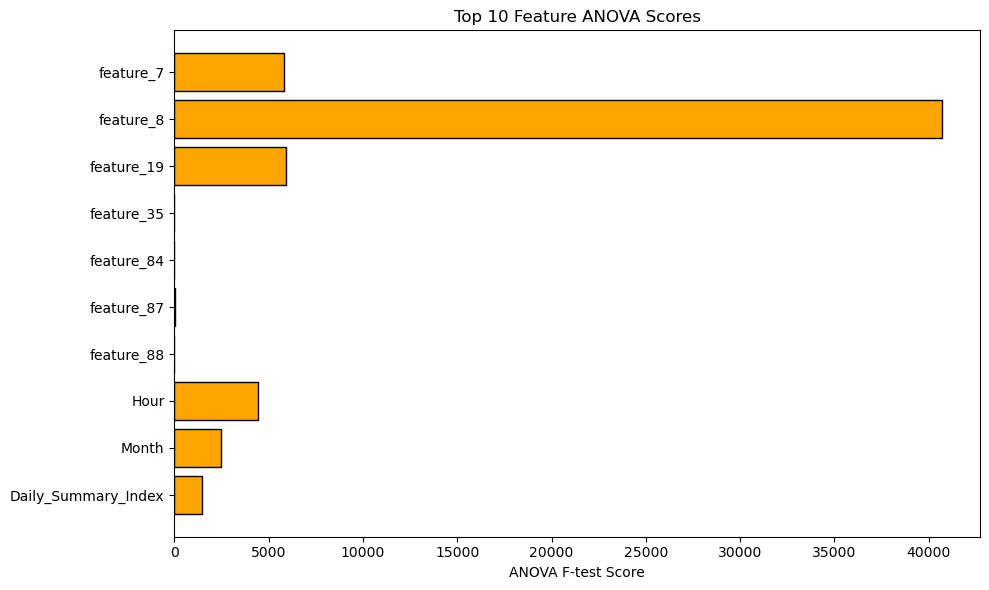

In [12]:
# Plot Anova Scores for Top Features
selected_scores = selector.scores_[selector.get_support(indices=True)]

plt.figure(figsize=(10, 6))
plt.barh(selected_features, selected_scores, color='orange', edgecolor='black')
plt.xlabel("ANOVA F-test Score")
plt.title("Top 10 Feature ANOVA Scores")
plt.gca().invert_yaxis() 
plt.tight_layout()
plt.show()

In [13]:
from pyspark.ml.feature import VectorAssembler, StandardScaler
from pyspark.ml.regression import LinearRegression
from sklearn.metrics import mean_squared_error, root_mean_squared_error
import numpy as np

selected_features = selected_features.tolist()

# Assemble the selected features into a feature vector
assembler = VectorAssembler(inputCols=selected_features, outputCol="features")
df_assembled = assembler.transform(df_selected)

scaler = StandardScaler(inputCol="features", outputCol="scaled_features", withMean=True, withStd=True)
scaler_model = scaler.fit(df_assembled)
df_scaled = scaler_model.transform(df_assembled)

train_df, test_df = df_scaled.randomSplit([0.8, 0.2], seed=42)

print(f"Training Set Size: {train_df.count()}")
print(f"Test Set Size: {test_df.count()}")

selected_features = selected_features

def compute_metrics(predictions_spark):
    predictions_pd = predictions_spark.select("prediction", "Temperature (C)").toPandas()
    
    y_true = predictions_pd["Temperature (C)"].values
    y_pred = predictions_pd["prediction"].values
    
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    
    return mse, rmse
    
# Linear Regression 
lr = LinearRegression(featuresCol="scaled_features", labelCol="Temperature (C)", regParam=0.1, elasticNetParam=0)
lr_model = lr.fit(train_df)

train_preds = lr_model.transform(train_df)
test_preds = lr_model.transform(test_df)

train_mse_lr, train_rmse_lr = compute_metrics(train_preds)
test_mse_lr, test_rmse_lr = compute_metrics(test_preds)

print(f"Train MSE (No Regularization): {train_mse_lr}")
print(f"Test MSE (No Regularization): {test_mse_lr}")
print(f"Train RMSE (No Regularization): {train_rmse_lr}")
print(f"Test RMSE (No Regularization): {test_rmse_lr}")

Training Set Size: 63457


Test Set Size: 15621


25/01/05 17:01:21 WARN InstanceBuilder: Failed to load implementation from:dev.ludovic.netlib.blas.JNIBLAS
25/01/05 17:01:21 WARN InstanceBuilder: Failed to load implementation from:dev.ludovic.netlib.blas.VectorBLAS
25/01/05 17:01:21 WARN InstanceBuilder: Failed to load implementation from:dev.ludovic.netlib.lapack.JNILAPACK


Train MSE (No Regularization): 39.93304496905415
Test MSE (No Regularization): 40.48252813715665
Train RMSE (No Regularization): 6.319259843451142
Test RMSE (No Regularization): 6.362588163409341


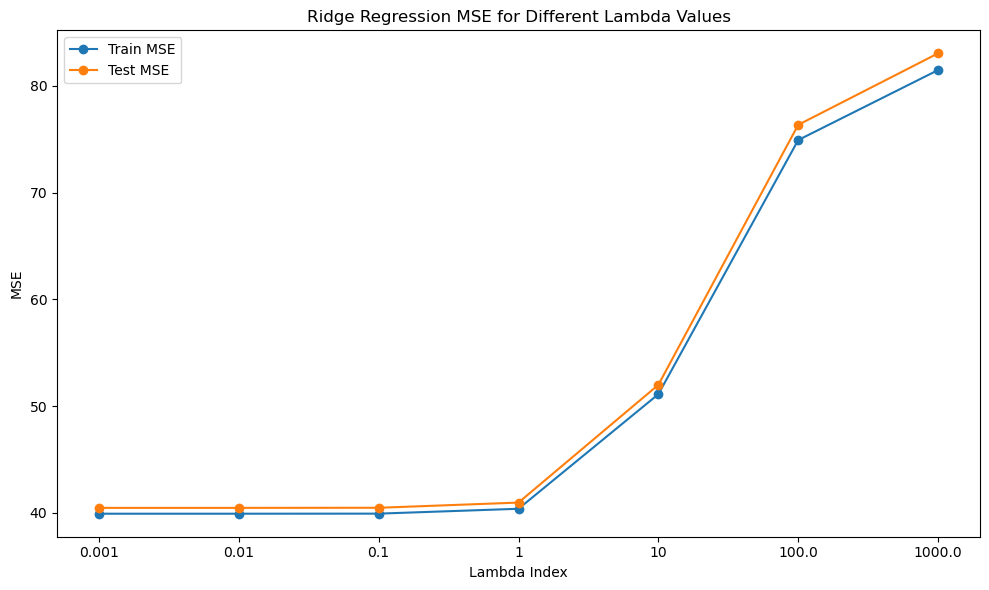

In [14]:
# Ridge Regression
ridge_train_mse = []
ridge_test_mse = []
lambda_vals = [1e-3, 1e-2, 0.1, 1, 10, 1e2, 1e3]

for lambda_val in lambda_vals:
    ridge = LinearRegression(featuresCol="scaled_features", labelCol="Temperature (C)", regParam=lambda_val, elasticNetParam=0)
    ridge_model = ridge.fit(train_df)
    
    train_preds = ridge_model.transform(train_df)
    test_preds = ridge_model.transform(test_df)
    
    mse_train, _ = compute_metrics(train_preds)
    mse_test, _ = compute_metrics(test_preds)
    
    ridge_train_mse.append(mse_train)
    ridge_test_mse.append(mse_test)

# Plot Ridge MSE for different lambda values
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(ridge_train_mse)+1), ridge_train_mse, label="Train MSE", marker='o')
plt.plot(range(1, len(ridge_test_mse)+1), ridge_test_mse, label="Test MSE", marker='o')
plt.xlabel("Lambda Index")
plt.ylabel("MSE")
plt.title("Ridge Regression MSE for Different Lambda Values")
plt.xticks(ticks=np.arange(1, len(lambda_vals)+1), labels=lambda_vals)
plt.legend()
plt.tight_layout()
plt.show()

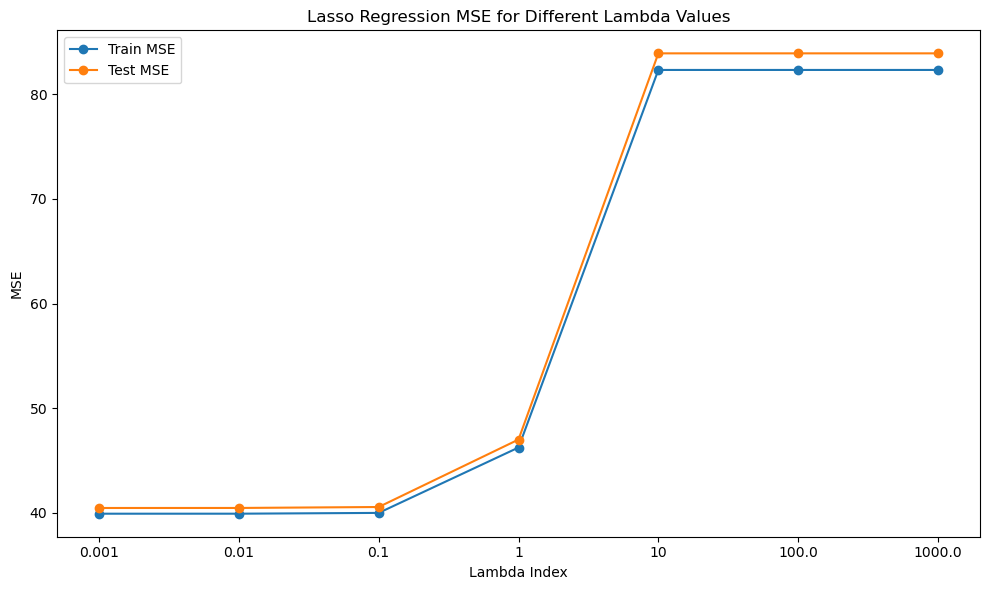

In [15]:
# Lasso Regression
lasso_train_mse = []
lasso_test_mse = []

for lambda_val in lambda_vals:
    lasso = LinearRegression(featuresCol="scaled_features", labelCol="Temperature (C)", regParam=lambda_val, elasticNetParam=1)
    lasso_model = lasso.fit(train_df)
    
    train_preds = lasso_model.transform(train_df)
    test_preds = lasso_model.transform(test_df)
    
    mse_train, _ = compute_metrics(train_preds)
    mse_test, _ = compute_metrics(test_preds)
    
    lasso_train_mse.append(mse_train)
    lasso_test_mse.append(mse_test)

# Plot Lasso MSE for different lambda values
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(lasso_train_mse)+1), lasso_train_mse, label="Train MSE", marker='o')
plt.plot(range(1, len(lasso_test_mse)+1), lasso_test_mse, label="Test MSE", marker='o')
plt.xlabel("Lambda Index")
plt.ylabel("MSE")
plt.title("Lasso Regression MSE for Different Lambda Values")
plt.xticks(ticks=np.arange(1, len(lambda_vals)+1), labels=lambda_vals)
plt.legend()
plt.tight_layout()
plt.show()

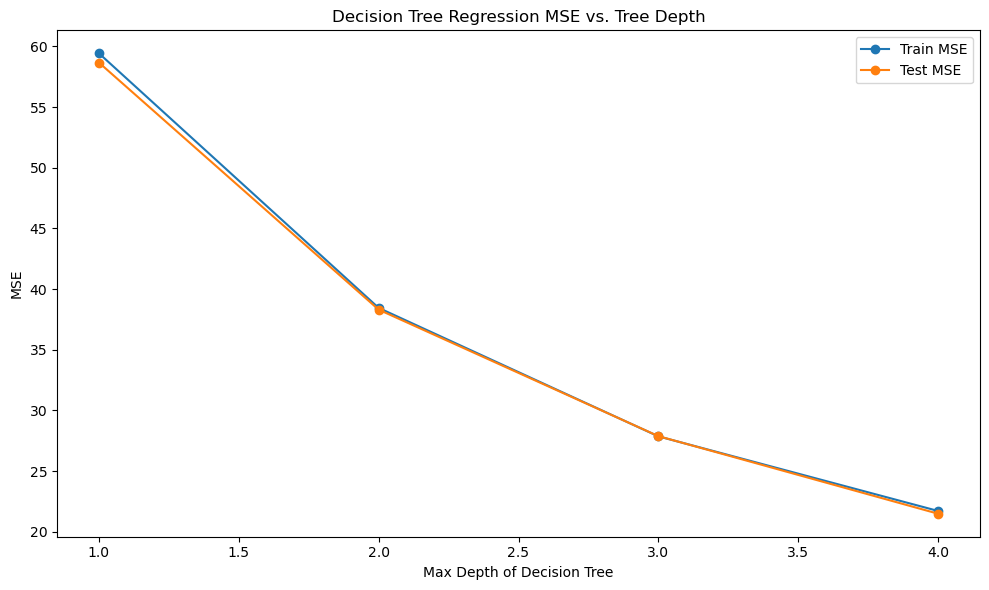

In [16]:
# Decision Tree 
from sklearn.preprocessing import StandardScaler

df_selected_pd = df_selected.toPandas()

X = df_selected_pd[selected_features].values
y = df_selected_pd["Temperature (C)"].values

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error

train_mse_dt = []
test_mse_dt = []
max_depths = range(1, 5)  

for depth in max_depths:
    dt = DecisionTreeRegressor(max_depth=depth, random_state=42)
    dt.fit(X_train, y_train)
    
    y_train_pred = dt.predict(X_train)
    y_test_pred = dt.predict(X_test)
    
    train_mse_dt.append(mean_squared_error(y_train, y_train_pred))
    test_mse_dt.append(mean_squared_error(y_test, y_test_pred))

# Plot MSE vs. Tree Depth
plt.figure(figsize=(10, 6))
plt.plot(max_depths, train_mse_dt, label='Train MSE', marker='o')
plt.plot(max_depths, test_mse_dt, label='Test MSE', marker='o')
plt.xlabel('Max Depth of Decision Tree')
plt.ylabel('MSE')
plt.title('Decision Tree Regression MSE vs. Tree Depth')
plt.legend()
plt.tight_layout()
plt.show()

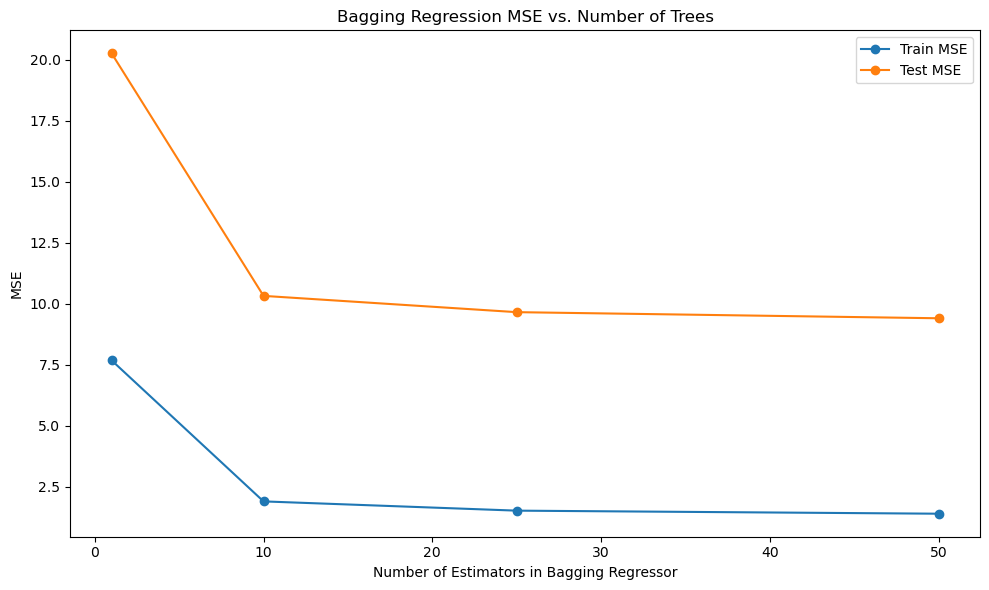

In [17]:
# Bagging
from sklearn.ensemble import BaggingRegressor
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt

train_mse_bagging = []
test_mse_bagging = []

num_trees_vals = [1, 10, 25, 50]

for num_trees in num_trees_vals:
    bagging_model = BaggingRegressor(random_state=42, n_estimators=num_trees)
    
    bagging_model.fit(X_train, y_train)
    
    y_train_pred = bagging_model.predict(X_train)
    y_test_pred = bagging_model.predict(X_test)
    
    train_mse_bagging.append(mean_squared_error(y_train, y_train_pred))
    test_mse_bagging.append(mean_squared_error(y_test, y_test_pred))

# Plot MSE vs. Number of Trees
plt.figure(figsize=(10, 6))
plt.plot(num_trees_vals, train_mse_bagging, label='Train MSE', marker='o')
plt.plot(num_trees_vals, test_mse_bagging, label='Test MSE', marker='o')
plt.xlabel('Number of Estimators in Bagging Regressor')
plt.ylabel('MSE')
plt.title('Bagging Regression MSE vs. Number of Trees')
plt.legend()
plt.tight_layout()
plt.show()

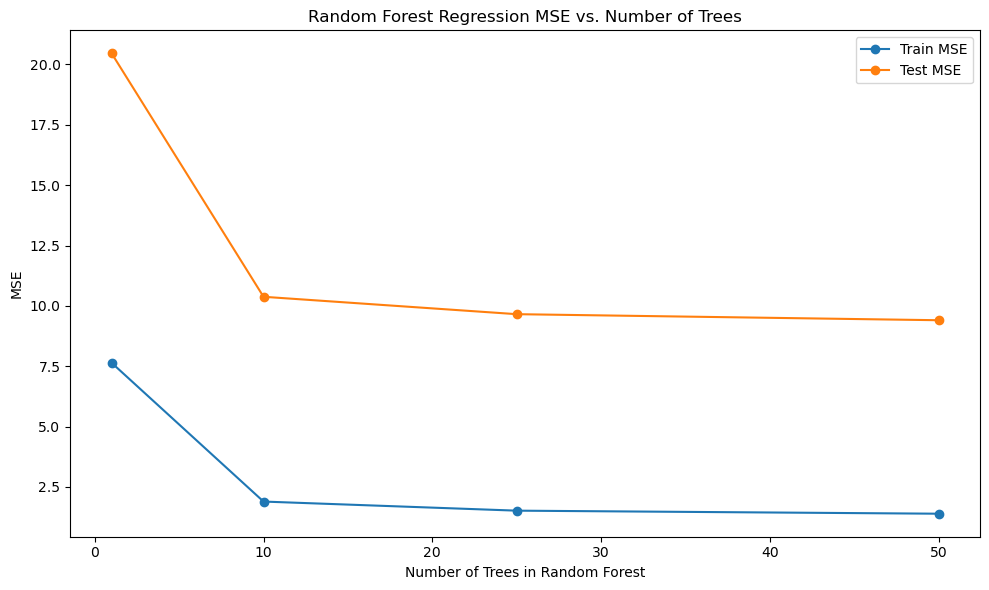

In [18]:
# Random Forest
from sklearn.ensemble import RandomForestRegressor

train_mse_rf = []
test_mse_rf = []

num_trees_vals = [1, 10, 25, 50]

for num_trees in num_trees_vals:
    rf_model = RandomForestRegressor(random_state=42, n_estimators=num_trees)
    
    rf_model.fit(X_train, y_train)
    
    y_train_pred_rf = rf_model.predict(X_train)
    y_test_pred_rf = rf_model.predict(X_test)
    
    train_mse_rf.append(mean_squared_error(y_train, y_train_pred_rf))
    test_mse_rf.append(mean_squared_error(y_test, y_test_pred_rf))

# Plot MSE vs. Number of Trees
plt.figure(figsize=(10, 6))
plt.plot(num_trees_vals, train_mse_rf, label='Train MSE', marker='o')
plt.plot(num_trees_vals, test_mse_rf, label='Test MSE', marker='o')
plt.xlabel('Number of Trees in Random Forest')
plt.ylabel('MSE')
plt.title('Random Forest Regression MSE vs. Number of Trees')
plt.legend()
plt.tight_layout()
plt.show()

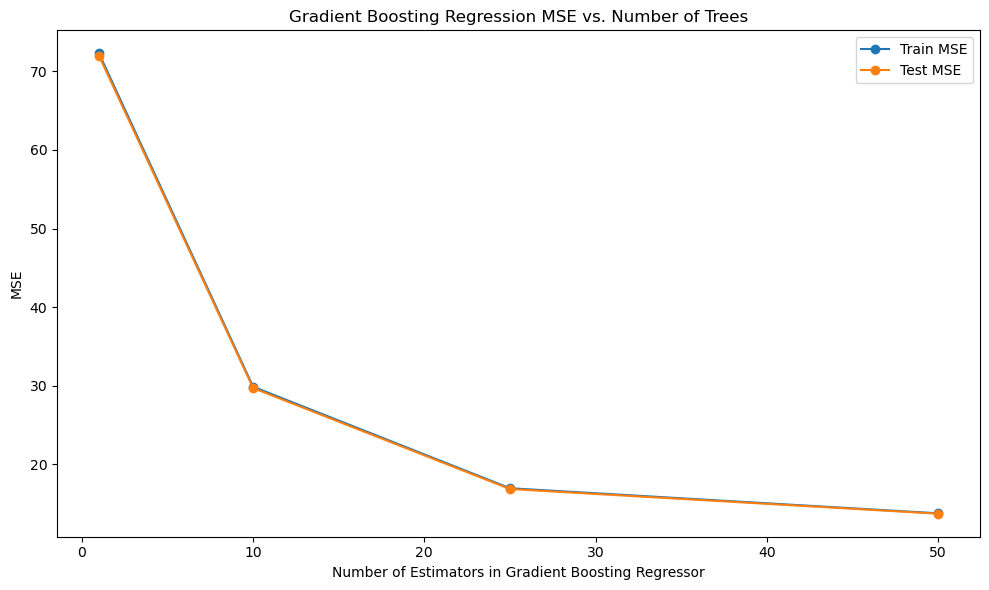

In [19]:
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt

train_mse_boosting = []
test_mse_boosting = []

num_trees_vals = [1, 10, 25, 50]

for num_trees in num_trees_vals:
    boosting_model = GradientBoostingRegressor(random_state=42, n_estimators=num_trees, loss='squared_error')
    
    boosting_model.fit(X_train, y_train)
    
    y_train_pred = boosting_model.predict(X_train)
    y_test_pred = boosting_model.predict(X_test)
    
    train_mse_boosting.append(mean_squared_error(y_train, y_train_pred))
    test_mse_boosting.append(mean_squared_error(y_test, y_test_pred))

# Plot MSE vs. Number of Trees for Gradient Boosting Regressor
plt.figure(figsize=(10, 6))
plt.plot(num_trees_vals, train_mse_boosting, label='Train MSE', marker='o')
plt.plot(num_trees_vals, test_mse_boosting, label='Test MSE', marker='o')
plt.xlabel('Number of Estimators in Gradient Boosting Regressor')
plt.ylabel('MSE')
plt.title('Gradient Boosting Regression MSE vs. Number of Trees')
plt.legend()
plt.tight_layout()
plt.show()


Final Gradient Boosting Model Performance:
Train MSE: 9.6851, Test MSE: 10.6464
Train RMSE: 3.1121, Test RMSE: 3.2629
Train MAE: 2.4618, Test MAE: 2.5725



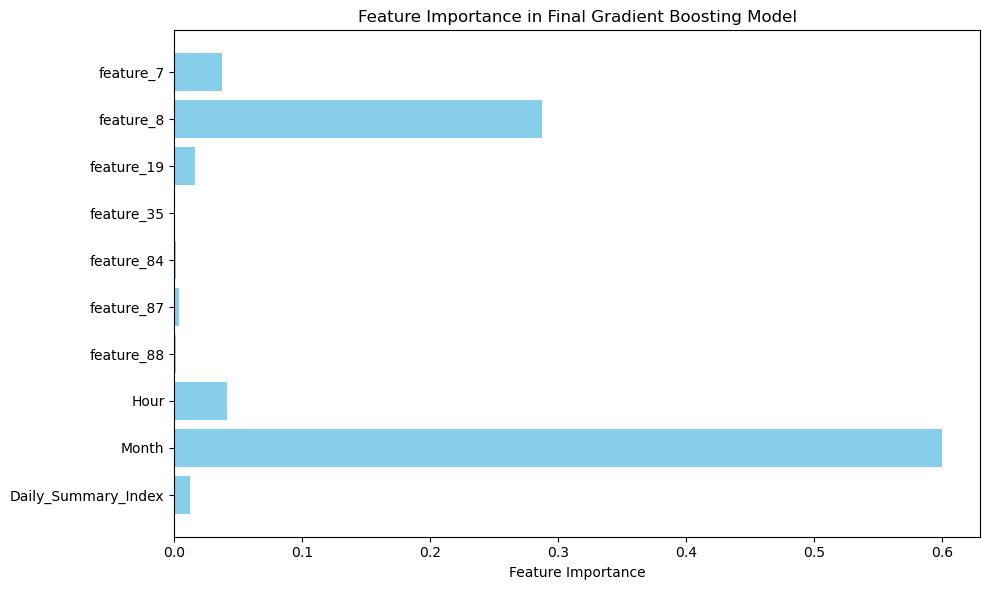

In [20]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
import numpy as np

def print_model_performance(y_train, y_train_pred, y_test, y_test_pred, model_name):
    train_mse = mean_squared_error(y_train, y_train_pred)
    test_mse = mean_squared_error(y_test, y_test_pred)
    train_rmse = np.sqrt(train_mse)
    test_rmse = np.sqrt(test_mse)
    train_mae = mean_absolute_error(y_train, y_train_pred)
    test_mae = mean_absolute_error(y_test, y_test_pred)
    
    print(f"\n{model_name} Performance:")
    print(f"Train MSE: {train_mse:.4f}, Test MSE: {test_mse:.4f}")
    print(f"Train RMSE: {train_rmse:.4f}, Test RMSE: {test_rmse:.4f}")
    print(f"Train MAE: {train_mae:.4f}, Test MAE: {test_mae:.4f}")


from sklearn.ensemble import GradientBoostingRegressor

final_model = GradientBoostingRegressor(random_state=42, n_estimators=500, max_depth=4)
final_model.fit(X_train, y_train)

y_train_pred_final = final_model.predict(X_train)
y_test_pred_final = final_model.predict(X_test)

print_model_performance(y_train, y_train_pred_final, y_test, y_test_pred_final, "Final Gradient Boosting Model")
print()

import matplotlib.pyplot as plt

feature_importances = final_model.feature_importances_

# Plot feature importance
plt.figure(figsize=(10, 6))
plt.barh(selected_features, feature_importances, color="skyblue")
plt.xlabel("Feature Importance")
plt.title("Feature Importance in Final Gradient Boosting Model")
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

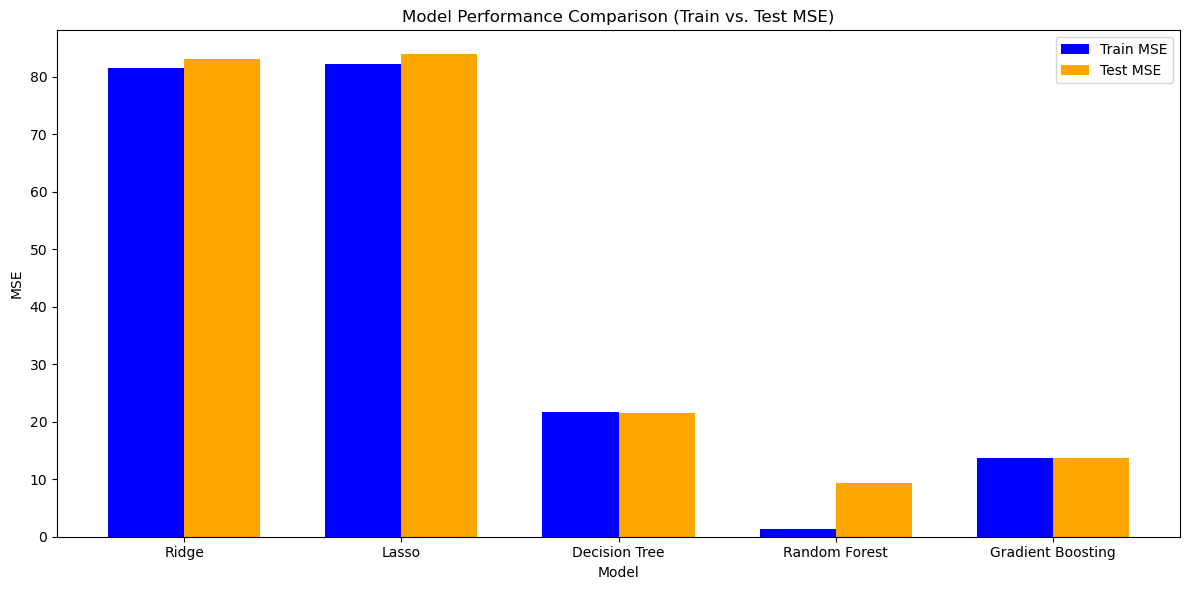

In [21]:
# Models and MSE values
models = ['Ridge', 'Lasso', 'Decision Tree', 'Random Forest', 'Gradient Boosting']
train_mse = [ridge_train_mse[-1], lasso_train_mse[-1], train_mse_dt[-1], train_mse_rf[-1], train_mse_boosting[-1]]
test_mse = [ridge_test_mse[-1], lasso_test_mse[-1], test_mse_dt[-1], test_mse_rf[-1], test_mse_boosting[-1]]

bar_width = 0.35
index = np.arange(len(models))

# Plot train and test MSE side-by-side
plt.figure(figsize=(12, 6))
plt.bar(index, train_mse, bar_width, color="blue", label="Train MSE")
plt.bar(index + bar_width, test_mse, bar_width, color="orange", label="Test MSE")

plt.xlabel("Model")
plt.ylabel("MSE")
plt.title("Model Performance Comparison (Train vs. Test MSE)")
plt.xticks(index + bar_width / 2, models)
plt.legend()
plt.tight_layout()
plt.show()

---

### Write your report here

# Weather Dataset Prediction Report

## Data Initialization
- Loaded the weather dataset using `PySpark` and displayed the initial data using df.show().
- Found the number of samples and features (excluding non-feature columns) in the dataset.
- Used `df.describe().show()` to display count, mean, std, etc., for the dataset.

## Data Preprocessing
- Checked for missing values using `df.select([count(when(col(c).isNull() | isnan(col(c)), c)).alias(c) for c in feature_cols]).show()`.
- Converted string features to floats for numerical processing.
- Filled `missing values` in feature columns with their median values to handle the skewed distributions.
- Dropped `duplicate samples` to ensure data quality.
- Removed outliers using `IQR method` which reduced error by `20%`.
- Extracted `Hour` and `Month` from the Formatted Date column for feature engineering.
- Calculated and plotted the correlation between Hour, Month, and Temperature (C).
- Applied one-hot encoding to the Daily Summary column using `StringIndexer`.

## Feature Scaling and Dataset Splitting
- Assembled selected features into a feature vector using `VectorAssembler`.
- `Standardized and normalized` features using MinMaxScaler to handle different scales and skewed numerical features.
- Decided the top 10 features based on `ANOVA F-test scores` using SelectKBest and selected them in PySpark
- Split the dataset into training and testing sets using `train_test_split`.


## Model Training and Evaluation

### Linear Regression
- This test model trained using a linear regression model without regularization.
- **Results**
    - Train MSE: `39.93304496905415`
    - Test MSE: `40.48252813715665`
    - Train RMSE: `6.319259843451142`
    - Test RMSE: `6.362588163409341`
- The model showed consistent performance on both training and test sets, which shows minimal overfitting.

### Ridge Regression
- This test model tested accuracy with different lamda values for different regularization strengths
- Here, I trained the model with lambda values `[0.001, 0.01, 0.1, 1, 10, 100, 1000]`.
- **Results**
    - Train MSE increased slightly with higher lambda, and shot up after lamba at `100` which indicates increased bias.
    - Test MSE was similar to the train MSE which was good for this model as it indicated less overfitting.
- The model performed best with lower regularization, suggesting that the data didn't benefit much from ridge regularization.

### Lasso Regression
- This test model also tested accuracy with different lamda values for different regularization strengths
- Here, I trained the model with lambda values `[0.001, 0.01, 0.1, 1, 10, 100, 1000]`.
- **Results**
    - Train MSE increased slightly with higher lambda, and shot up after lamba at `10` and remained constant at mse of over `80`.
    - Test MSE was similar to the train MSE which was good for this model as it indicated minimal overfitting.
- The model performed best with minimal regularization.
  
### Decision Tree Regression
- Here, I evaluated the decision tree regression with varying tree depths `[1, 2, 3, 4]`.
- **Results**
    - Train MSE decreased with increased depth, indicating the model being better fit to the training data.
    - Test MSE also decreased similarly to Train MSE which indicates minimal overfitting.
- The model risked generalizaiton beyond a certain depth.

### Random Forest Regression
- Here, I evaluated the decision tree regression with different numbers of trees `[1, 10, 25, 50]`.
- **Results**
    - Train MSE decreased by around `50%`, and after that it decreased at a small rate in subsequent trees, indicating stabalization.
    - Test MSE had almost `one third` of the MSE of Train MSE but decreased similarly at around `50%` and then stabalized after that.
- The model showed strong performance with 25 or more trees.
- Boosting was one of the methods used here which helped improve the accuracy of this dataset where all features are considered.

### Gradient Boosting Regression
- Here, I trained the gradient boosting regression models with different numbers of estimators `[1, 10, 25, 50]`.
- **Results**
    - Train MSE decreased significantly with more estimators and stabalized at around 25 estimators, which showed improved learning.
    - Test MSE also decreased similarly, indicated similar predictive perfromance.
- The model continued to improve with more estimators, with its best performance at 50 estimators.

## Final Model Selection and Evaluation
- From all the findings, the **Gradient Boosting Regression Model** was the best model. This model consistently achieved lower MSE on both training and test sets, with `num_trees_vals=50` and `max_depth=4` providing optimal performance. The model had low gap between the training and test sets which indicated minimal overfitting.

### Final Gradient Boosting Model Performance:
- Train MSE: `9.6851`
- Test MSE: `10.6464`
- Train RMSE: `3.1121`
- Test RMSE: `3.2629`
- Train MAE: `2.4618`
- Test MAE: `2.5725`
- The feature importance plot showed which features contributed most to the model, which helped understand the model better. The best features in this dataset were Feature8, Month, Feature19 and Hour features which consistently gave higher feature importance.

## Model Performance Comparison
- I also ran a comparison of the different models:
  
- Ridge Regression
    - Train MSE: Higher at larger lambda values.
    - Test MSE: Best at lower lambda, indicating minimal regularization is optimal.
- Lasso Regression
    - Train MSE: Increased with higher lambda.
    - Test MSE: Increased with higher lambda.
- Decision Tree Regression
    - Train MSE: Decreased with depth but risked overfitting.
    - Test MSE: Best at highest depth.
- Random Forest Regression
    - Train MSE: Improved with more trees.
    - Test MSE: Stabalized after 10 trees.
- Gradient Boosting Regression
    - Train MSE: Significantly lower with more estimators.
    - Test MSE: Consistently the lowest among all models.

### Conclusion 
- Based on the above results, the Gradient Boosting Model was the most suitable for predicting temperature using the weather dataset. It als provided the best balance between bias and variance, and the lowest errors on both training and test data. I feel the Gradient Boosting Model showed strong predictive accuracy by minimizing errors, allowing it to capture tough patterns in the data without overfitting. Its performance was superior to other models, including Random Forest and Decision Tree, as it effectively handled the feature interactions.

### What I have learned?
- Through this assignment, I learned the importance of data preprocessing, feature engineering, and hyperparameter tuning in enhancing model performance. Working with Pandas, Spark, Scikit-learned and other libraries helped me gain valuable experience into data pipelines, feature selection, for large datasets. This dataset was especially larger than what we've dealt with in previous homeworks. I also understood certain stengths and limitations of different models and their bias. Like, simple models like linear models vs ensemble models like Random Forest and Gradient Boostingaffted how the choce impacts our predictions. 

### How you might use what you learned in the future?
- In future, I plan to use these techniques various projects, workplacees to deal with time forecasting and enviromenttal data. I also understand the process of selecting the correct model for data which will help in real-world application. This project has helped me improve my practical application ability to apply machine learning concepts to predictive modeling, which I believe would be a very important skill in future jobs in most fields.

---